![IMG_5014.HEIC](attachment:fef4f534-edfe-46a6-a156-a9f4bb9ed9f3.HEIC)

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet


In [ ]:
#!g1.1
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet(root='./data', transform=transform, target_transform=target_transform, target_types='segmentation', download=True)
valid_dataset = OxfordIIITPet(root='./data', transform=transform, split='test', target_transform=target_transform, target_types='segmentation', download=True)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [ ]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [ ]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
#!g1.1
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch

    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [ ]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [ ]:
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )



In [ ]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels*4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels*2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels*4)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)
        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        residual3 = self.down3(x) # x.shape: (N // 4, N // 4, base_channels*2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3) # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)
        residual4 = self.down4(x)
        x = self.downsample(residual4)
        # LATENT SPACE DIMENSION DIM = N // 4
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 8

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N , N , base_channels)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up4(x)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 4, N // 4, base_channels * 4)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 4, N // 4, base_channels * 8)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 8) -> (N // 4, N // 4, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels) -> (N // 2, N // 2, base_channels)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N//2, N//2, base_channels) -> (N//2, N//2, base_channels * 2)
        x = self.up2(x)  # x.shape: (N//2, N//2, base_channels * 2) -> (N//2, N//2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N , N , base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [ ]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [ ]:
#!g1.1
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

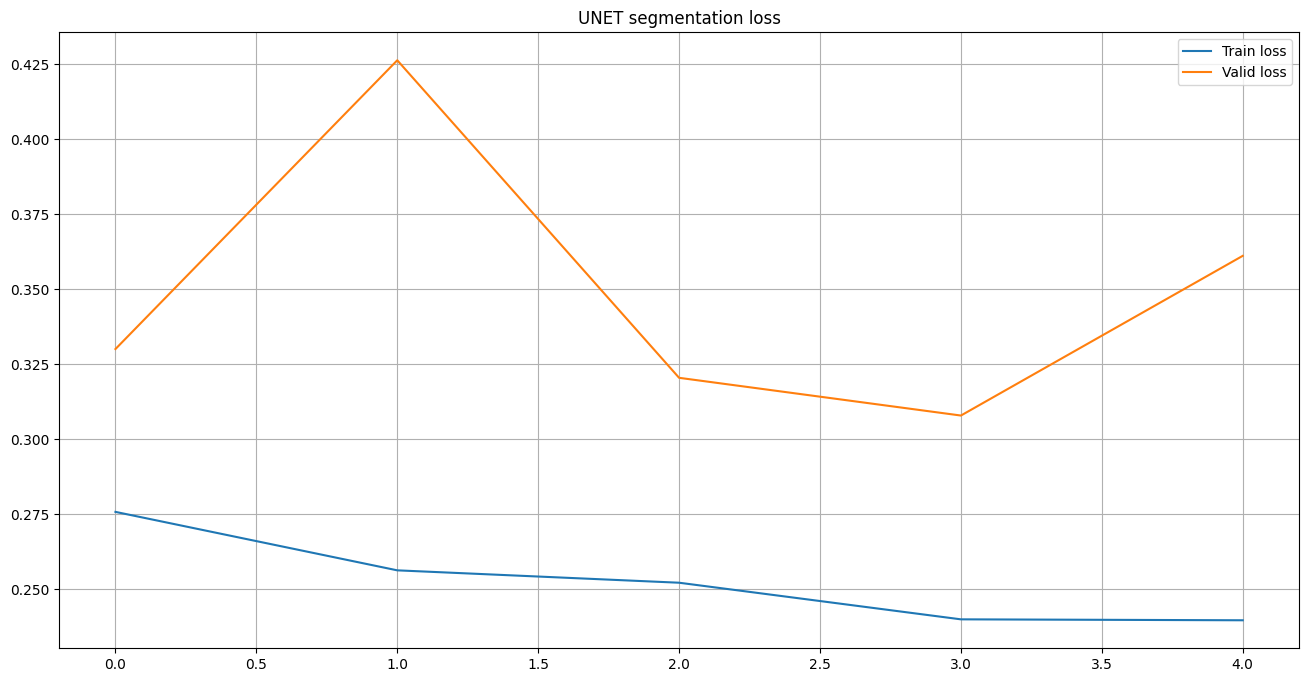

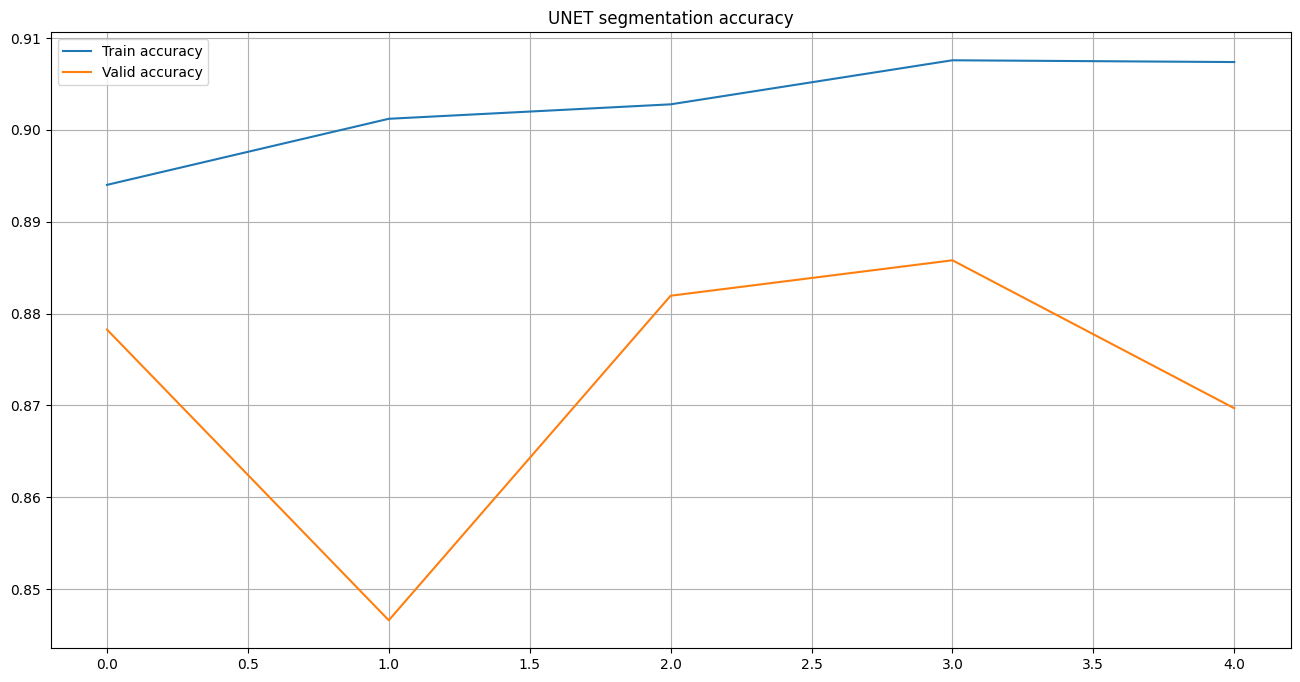

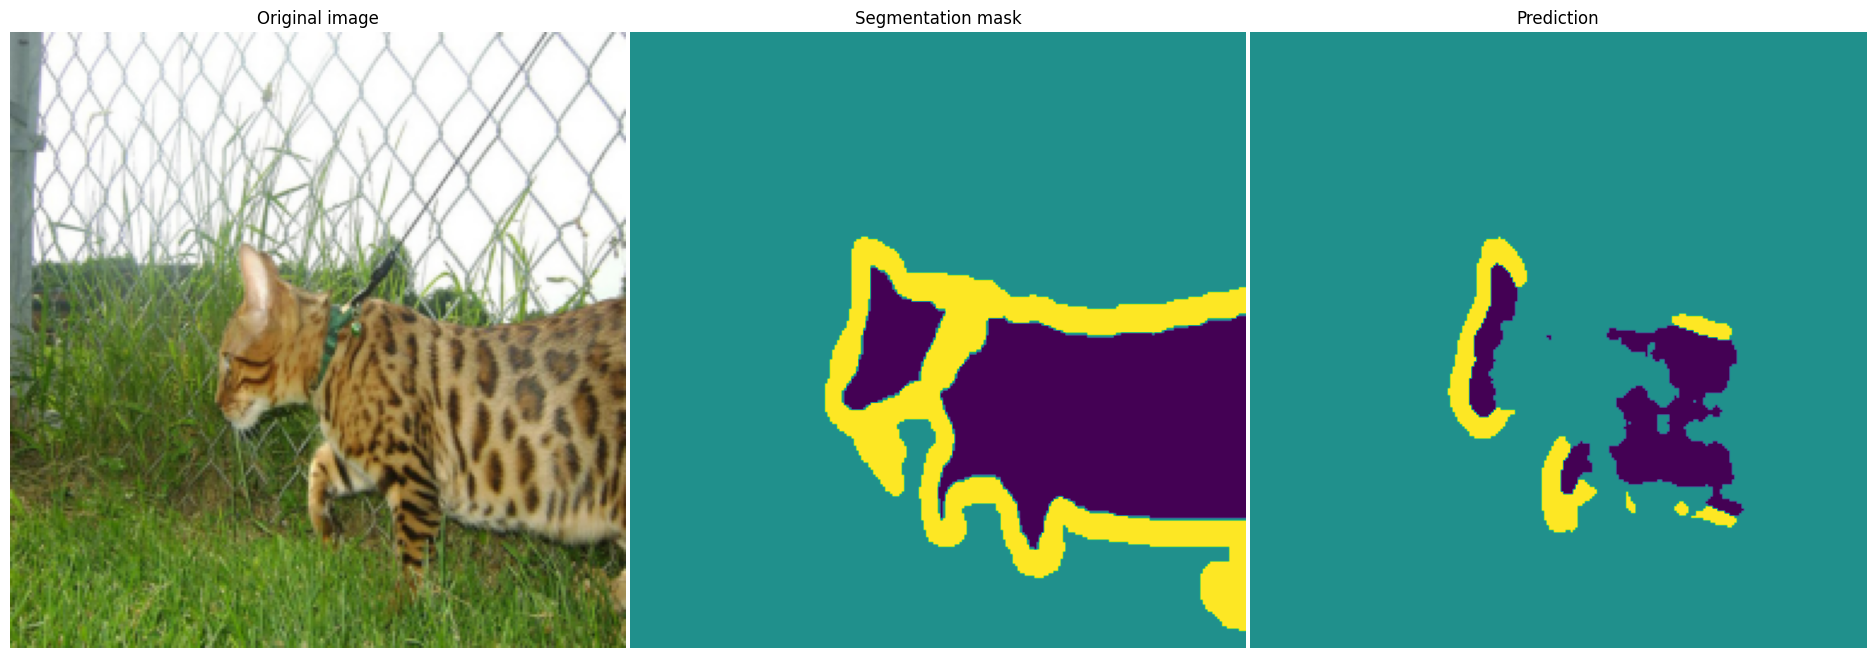

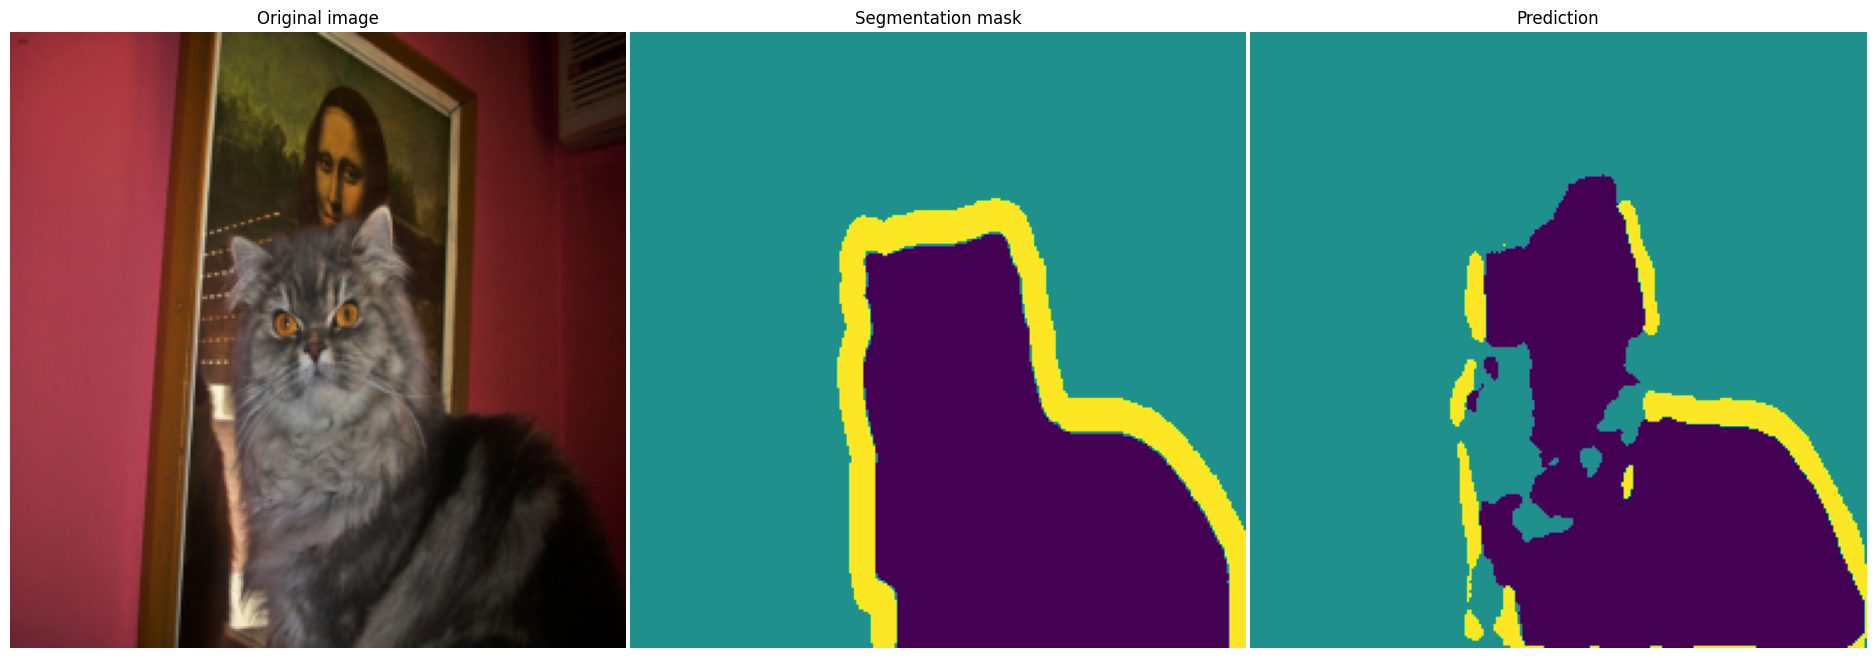

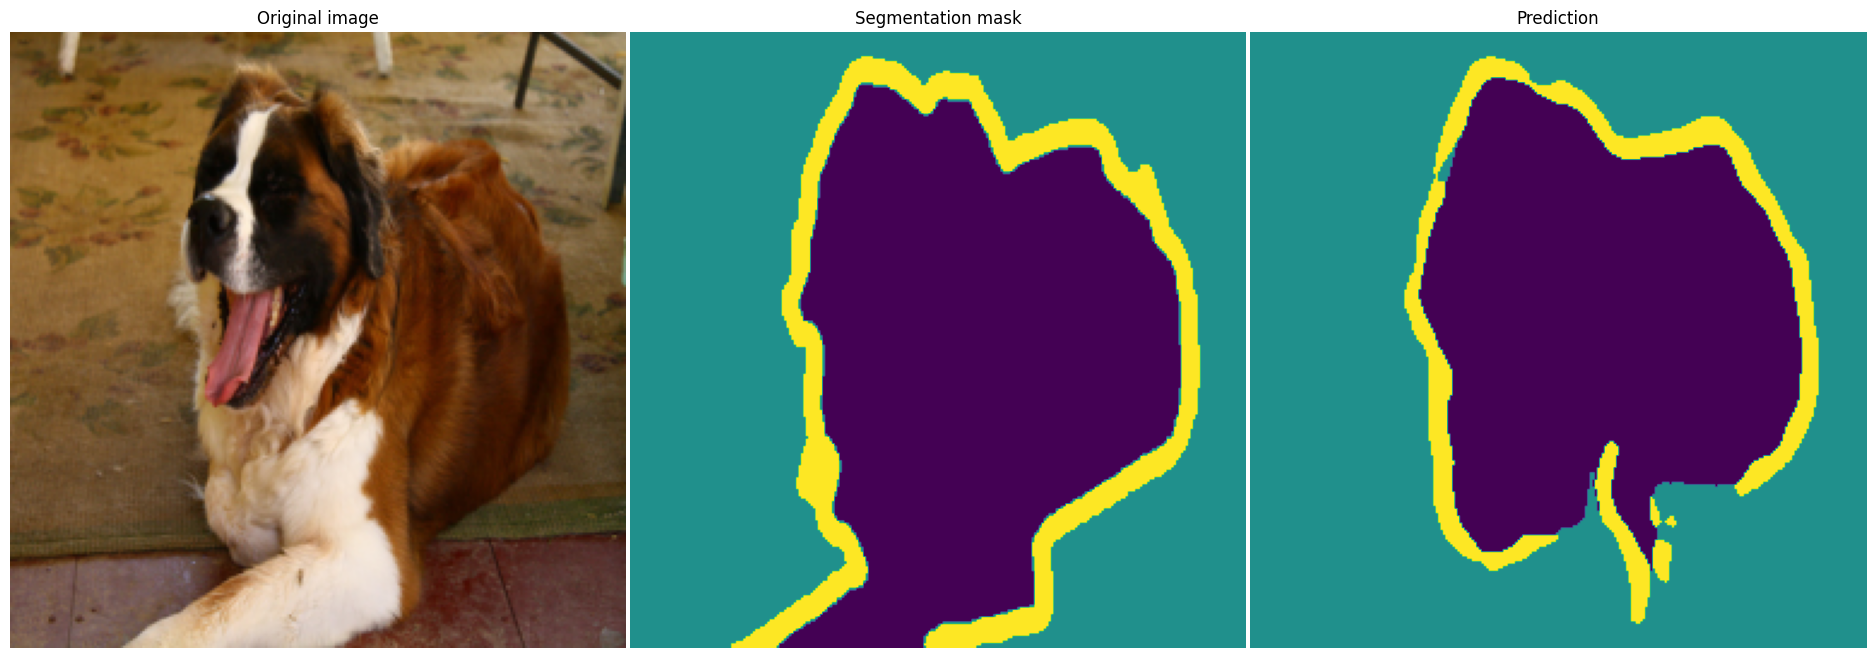

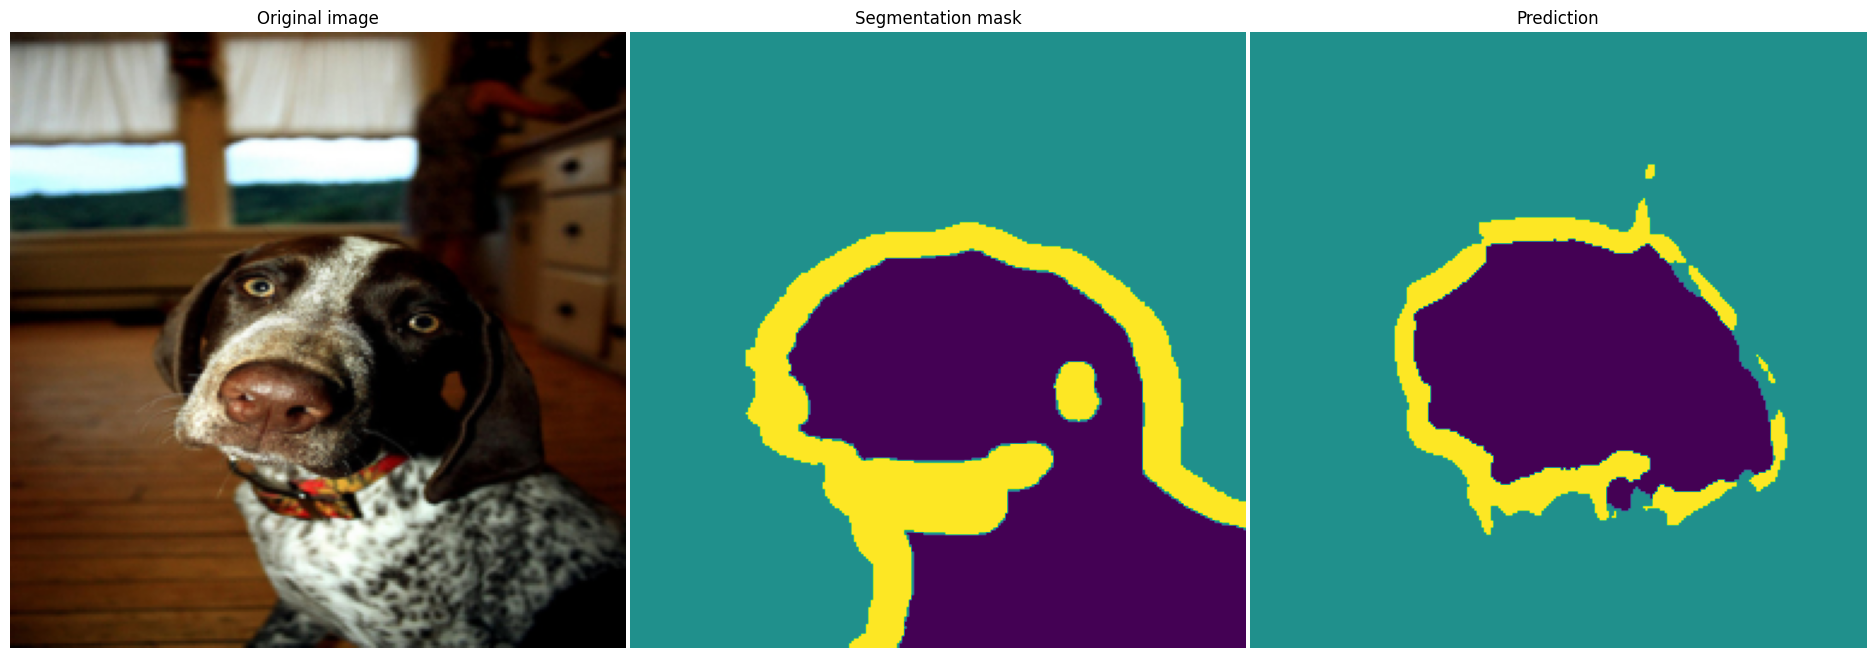

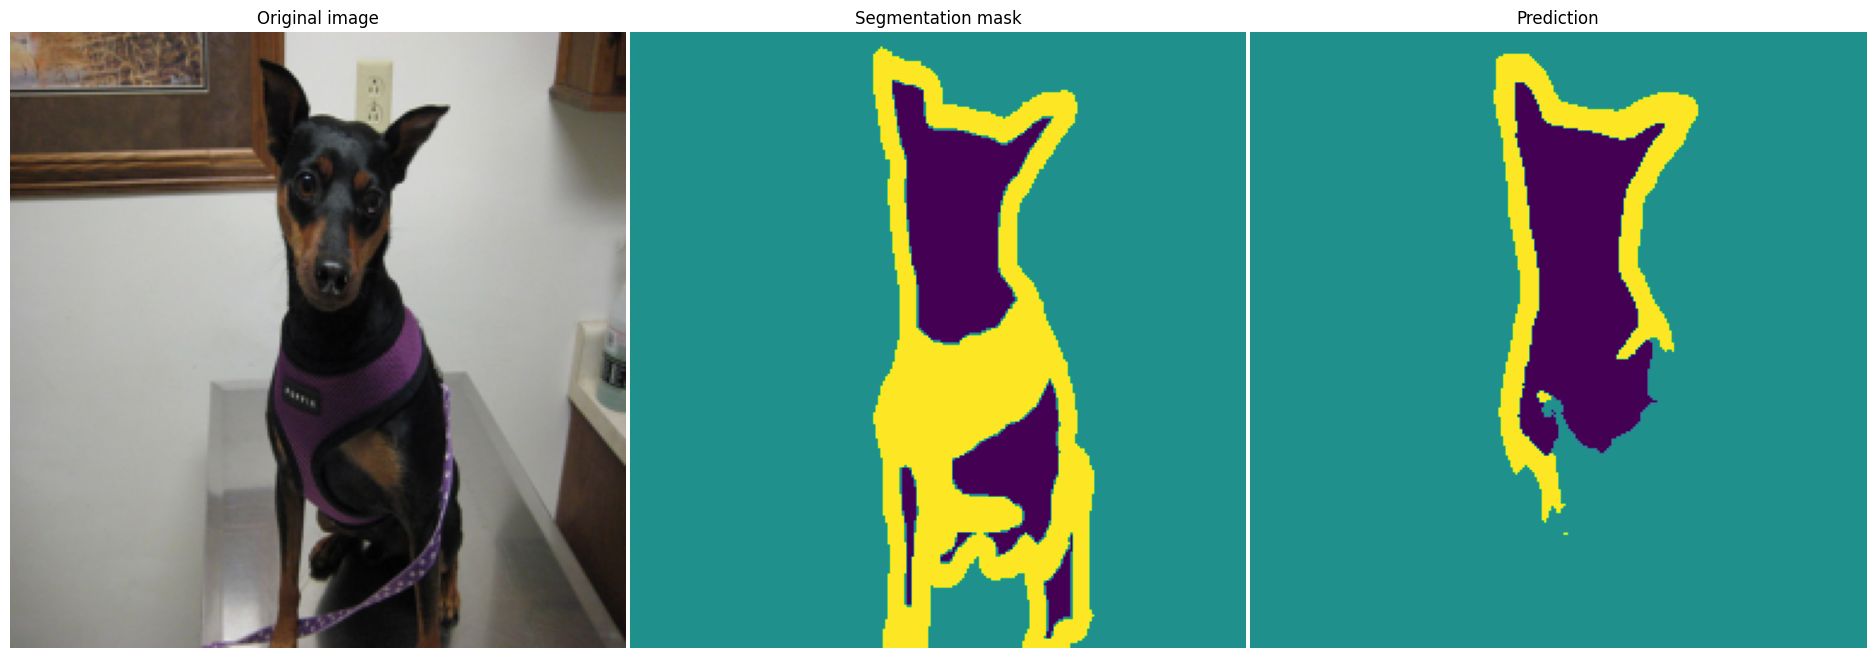

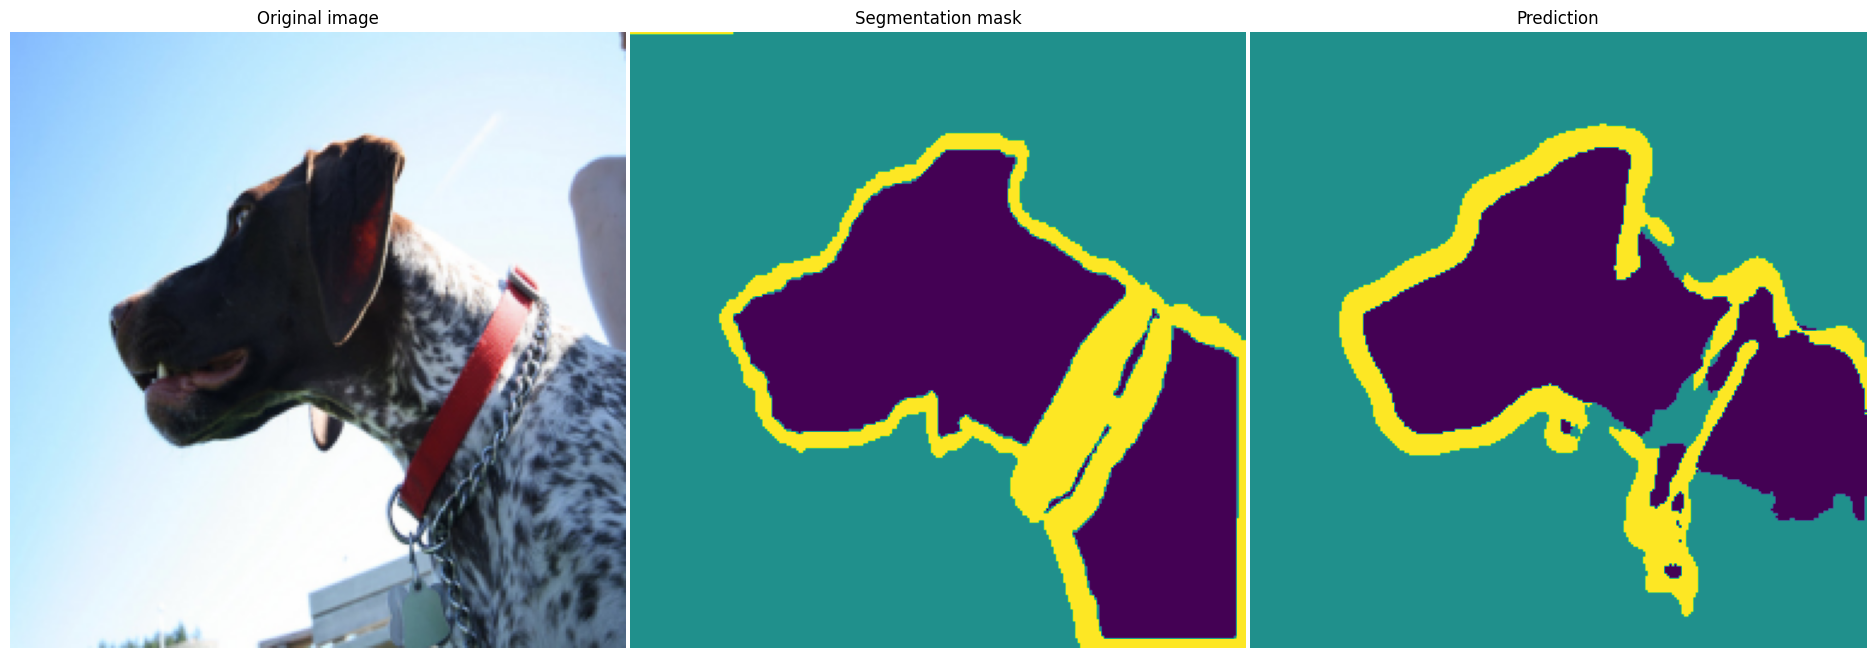

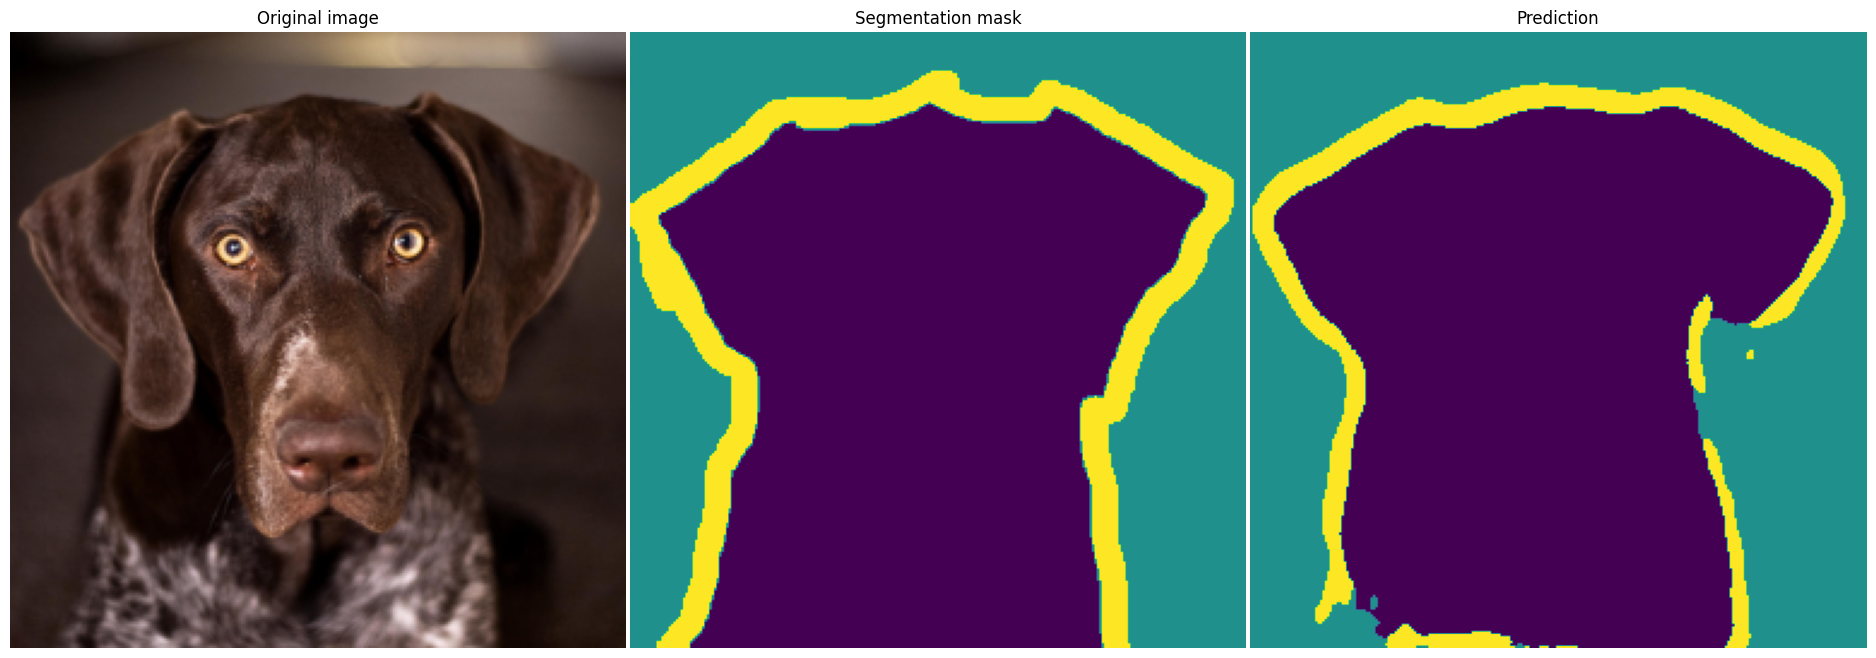

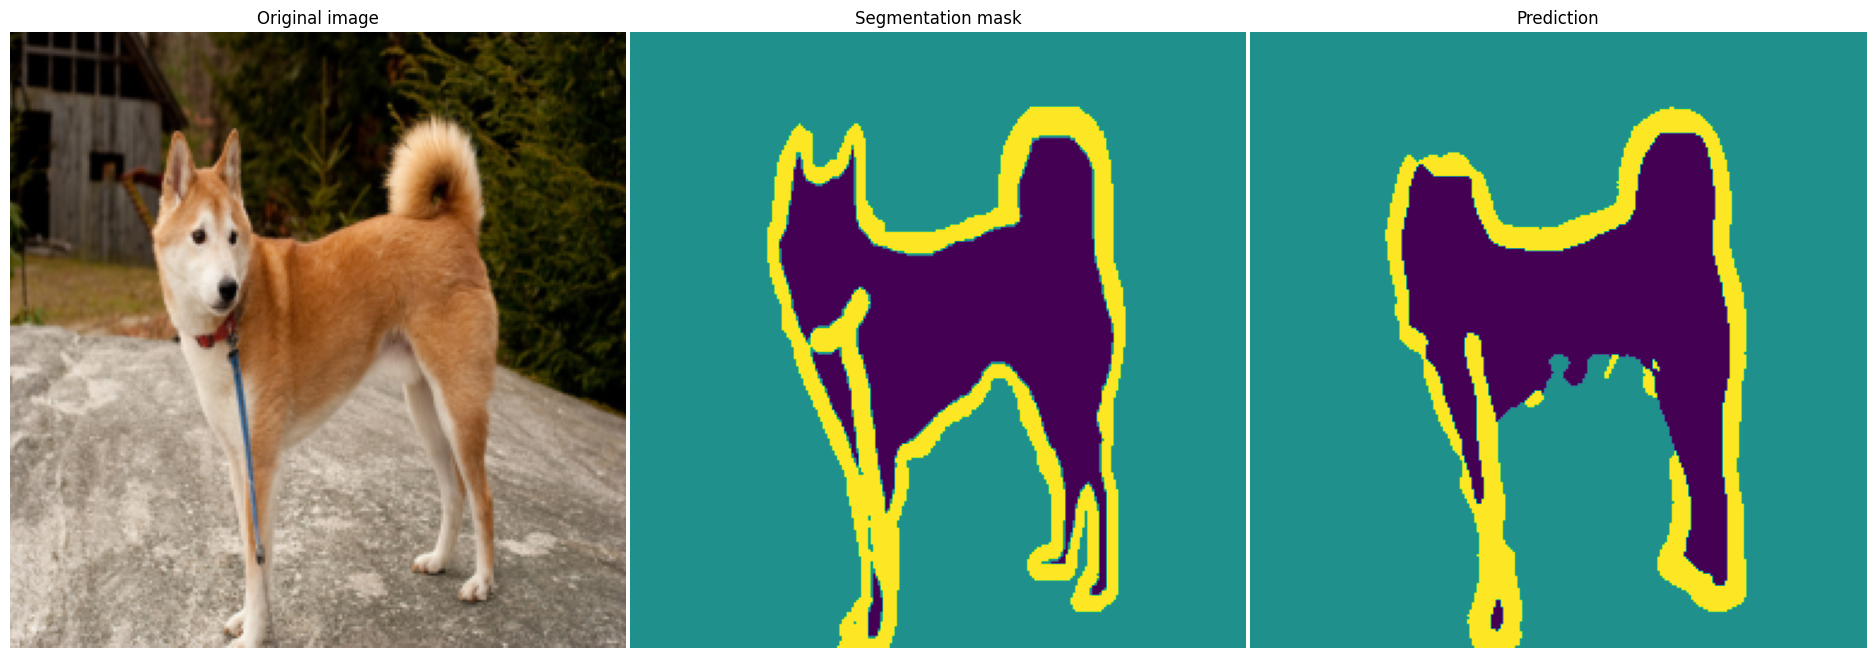

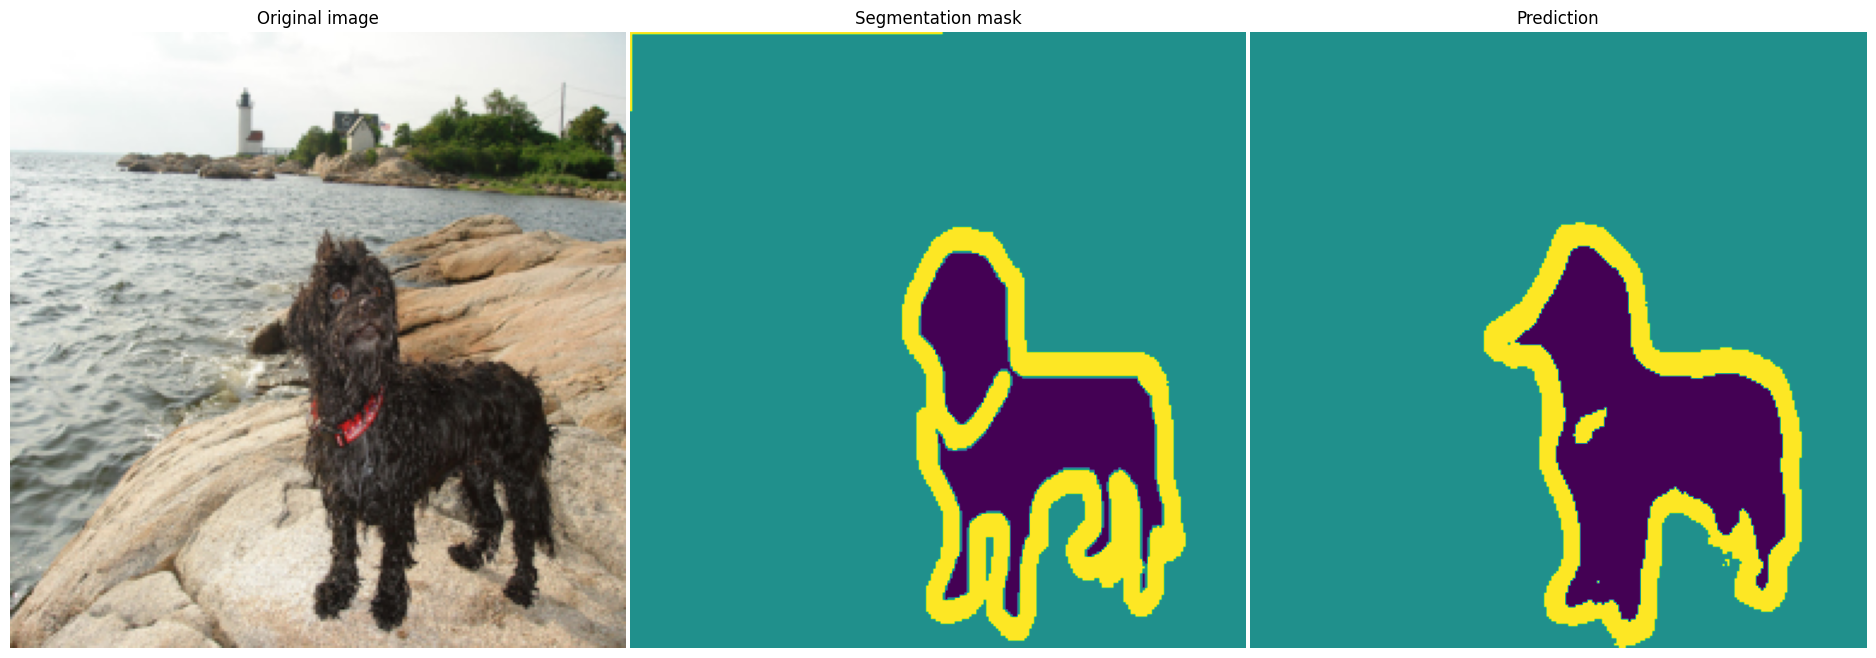

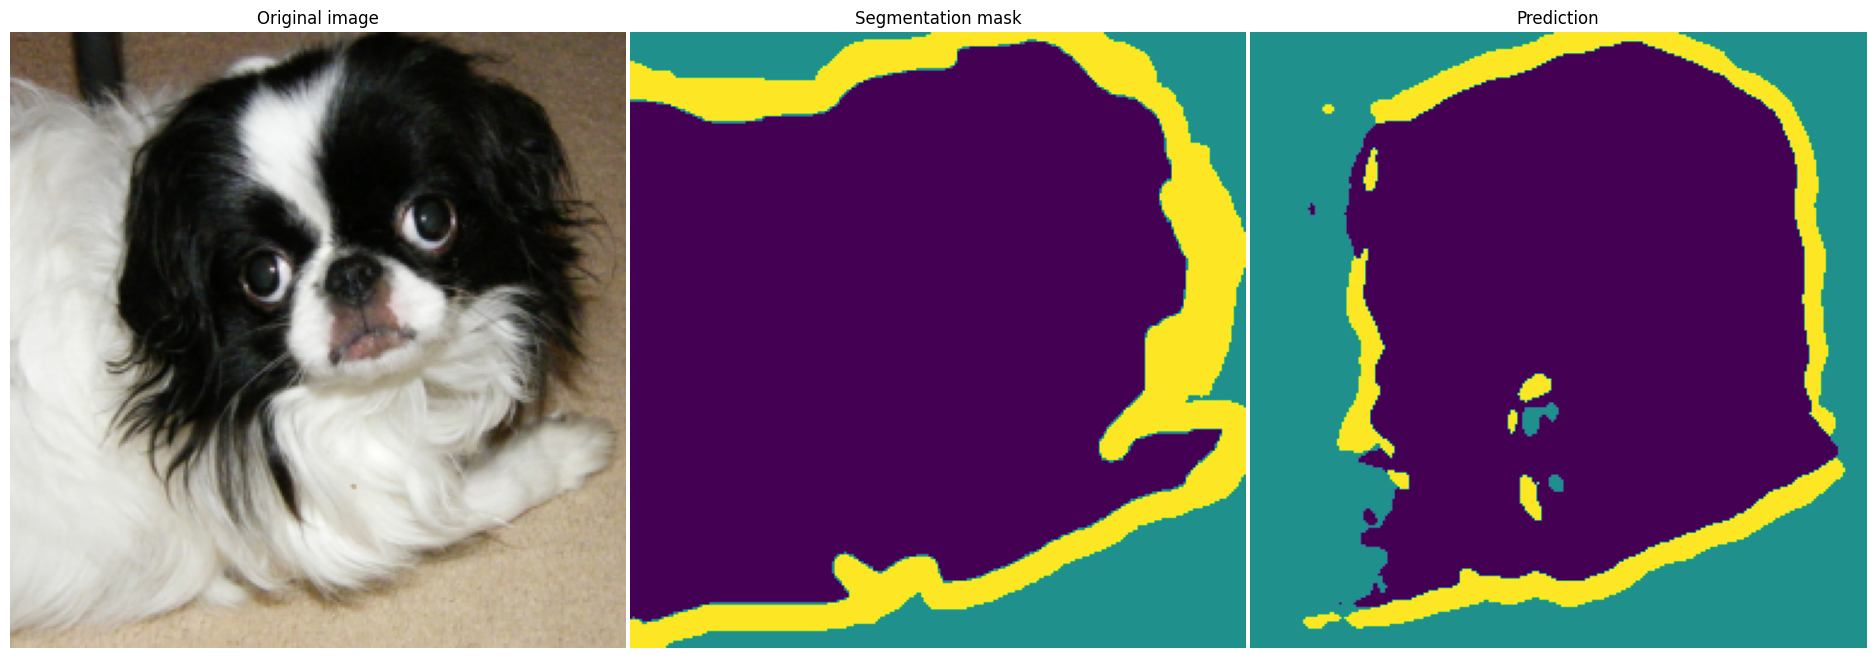

In [ ]:
whole_train_valid_cycle(model, 5, 'UNET segmentation')

In [ ]:
# 2 часть

In [2]:
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader

In [3]:
#!g1.1
def target_transform(voc_target):
    target = {}

    target['boxes'] = torch.tensor(
        [
            [
                float(x['bndbox']['xmin']),
                float(x['bndbox']['ymin']),
                float(x['bndbox']['xmax']),
                float(x['bndbox']['ymax'])
            ] for x in voc_target['annotation']['object']
        ],
        dtype=torch.float32
    )
    target['labels'] = torch.tensor([target2idx[x['name']] for x in voc_target['annotation']['object']], dtype=torch.int64)

    return target

In [5]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    return zip(*batch)
   
resize_transform = T.Compose([
    T.Resize((800, 800)),  # Задаем нужный размер
    T.ToTensor(),  # Преобразуем изображение в тензор
])

dataset_train = VOCDetection(
    root = './data',
    image_set='train',
    transform=T.ToTensor(),
    target_transform=target_transform,
    download=True
)

dataset_test = VOCDetection(
    root = './data',
    image_set='val',
    transform=T.ToTensor(),
    target_transform=target_transform,
    download=True
)

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True,pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset_test, batch_size=4, shuffle=False, pin_memory=True, collate_fn=collate_fn)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [6]:
dataset = VOCDetection('./data', image_set='train', download=True)
target_names = []

for obj in dataset:
    target_names.extend([x['name'] for x in obj[1]['annotation']['object']])

target_names = list(set(target_names))

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_detection_model():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    
    model.roi_heads.box_predictor = FastRCNNPredictor(1024, len(target_names))
    
    return model

In [ ]:
import torchvision.models as models
from torchvision.models.detection.retinanet import RetinaNet, RetinaNetHead
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.nn as nn
num_classes = len(target_names)  # Пример, target_names - это список всех классов + фон
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Загружаем backbone для RetinaNet (например, ResNet50 с FPN)
backbone = resnet_fpn_backbone('resnet18', pretrained=True)

# Создаем модель RetinaNet с новым количеством классов
model = RetinaNet(backbone, num_classes=num_classes).to(device)

# Переносим модель на GPU (если есть несколько GPU, используем DataParallel)



In [7]:
target2idx = {name: i for i, name in enumerate(target_names)}
idx2target = {i: name for i, name in enumerate(target_names)}

target2idx, idx2target

({'pottedplant': 0,
  'bottle': 1,
  'chair': 2,
  'person': 3,
  'aeroplane': 4,
  'sofa': 5,
  'boat': 6,
  'diningtable': 7,
  'tvmonitor': 8,
  'motorbike': 9,
  'bird': 10,
  'bus': 11,
  'dog': 12,
  'cat': 13,
  'bicycle': 14,
  'car': 15,
  'train': 16,
  'cow': 17,
  'sheep': 18,
  'horse': 19},
 {0: 'pottedplant',
  1: 'bottle',
  2: 'chair',
  3: 'person',
  4: 'aeroplane',
  5: 'sofa',
  6: 'boat',
  7: 'diningtable',
  8: 'tvmonitor',
  9: 'motorbike',
  10: 'bird',
  11: 'bus',
  12: 'dog',
  13: 'cat',
  14: 'bicycle',
  15: 'car',
  16: 'train',
  17: 'cow',
  18: 'sheep',
  19: 'horse'})

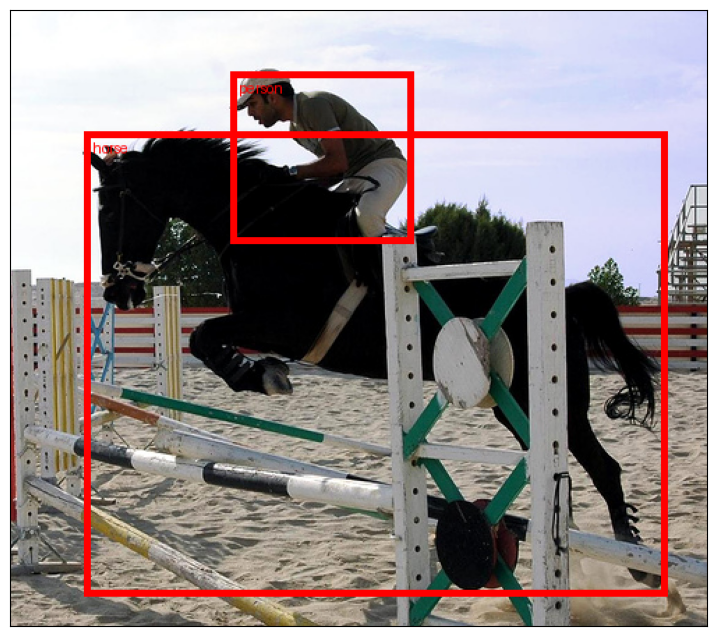

In [8]:
#!g1.1
from torchvision.utils import draw_bounding_boxes
import numpy as np


def show(imgs):
    to_pil = T.ToPILImage()
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 8))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def draw_boxes_single_image(image, boxes, labels):
    colors = ["red" for _ in boxes]

    show(draw_bounding_boxes(image, boxes, labels, colors=colors, width=5))
#!g1.1
draw_boxes_single_image(
    T.PILToTensor()(dataset[0][0]),
    target_transform(dataset[0][1])['boxes'],
    [idx2target[label.item()] for label in target_transform(dataset[0][1])['labels']]
)

In [32]:
#!g1.1
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import batched_nms


def intersection_over_union(dt_bbox, gt_bbox):
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])

    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)


def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

@torch.inference_mode()
def visualize(model, batch):
    # Проверяем, что batch не пуст
    if not batch or len(batch) < 2:
        print(f"Invalid batch: {batch}")
        return

    xs, ys = batch

    # Проверяем, что xs и ys содержат данные
    if xs is None or ys is None or len(xs) == 0 or len(ys) == 0:
        print(f"Error: One of the elements in batch is None or empty.")
        return

    model.eval()

    to_pil = T.ToPILImage()
    to_tensor = T.PILToTensor()

    # Процесс визуализации
    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}

        prediction = apply_nms(prediction)

        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idx2target[label.item()] for label in y['labels']], width=5, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idx2target[label.item()] for label in prediction['labels']], width=5, colors='red')

        fig, ax = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [25]:
#!g1.1
def train(model):
    model.train()
    a = []
    for x, y in tqdm(train_loader, desc='Train'):
        x = list(_.to(device).float() for _ in x)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        optimizer.zero_grad()

        output = model(x, y)
        
        loss_sum = sum(loss for loss in output.values())



        loss_sum.backward()

        optimizer.step()


In [26]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    
    metric = MeanAveragePrecision()

    for x, y in tqdm(loader, desc='Evaluation'):
        x = list(_.to(device).float() for _ in x)

        output = model(x, y)
        
        output = [{k: v.cpu() for k, v in t.items()} for t in output]

        metric.update(output, y)

    return metric.compute()['map']

In [27]:
#!g1.1

def plot_stats(
    train_map: list[float],
    valid_map: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' mAP')

    plt.plot(train_map, label='Train mAP')
    plt.plot(valid_map, label='Valid mAP')
    plt.legend()
    plt.grid()

    plt.show()

In [28]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    batch = next(iter(valid_loader))

    for epoch in range(num_epochs):
        train(model)
        clear_output()

        visualize(model, batch)

In [22]:
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetHead, RetinaNetClassificationHead, RetinaNetRegressionHead


def get_retinanet_model():
    model = retinanet_resnet50_fpn(weights='RetinaNet_ResNet50_FPN_Weights.COCO_V1')

    # Получаем количество входных признаков для классификации
    in_features = model.head.classification_head.cls_logits.in_channels
    print('количество признаков ' + str(in_features))
    # Количество классов в задаче (включая фон)
    num_classes = len(target_names)
    print('количество классов ' + str(num_classes))
    print('было якорей ' + str(model.head.classification_head.cls_logits.weight.shape[0]))
    print('Количество якорей: ' + str(9))    
    # Заменяем классификатор на свой, указываем количество классов
    classification_head = RetinaNetClassificationHead(in_channels = in_features, num_classes = num_classes, num_anchors=9)
    print(classification_head)
    model.head.classification_head= classification_head
    return model
model = get_retinanet_model().to(device)

количество признаков 256
количество классов 20
было якорей 819
Количество якорей: 9
RetinaNetClassificationHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [15]:

model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [29]:
from tqdm import tqdm
from IPython.display import clear_output
from tqdm import tqdm
from torch.optim import Adam
from torch import nn
optimizer = Adam(model.parameters(), lr=1e-5)

whole_train_valid_cycle(model, 3, 'Faster R-CNN finetune')

TypeError: object of type 'zip' has no len()

In [47]:
from tqdm import tqdm
from torch.optim import Adam
from torch import nn
optimizer = Adam(model.parameters(), lr=1e-5)

model.train()

for x, y in tqdm(train_loader, desc='Train'):
    
    x = list(_.to(device).float() for _ in x)
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    optimizer.zero_grad()
    
    output = model(x, y)

    print(output)
    
    loss_sum = sum(loss for loss in output.values())

    loss_sum.backward()

    optimizer.step()

Train:   0%|          | 1/2859 [00:00<14:04,  3.39it/s]

{'classification': tensor(1.1819, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2475, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 2/2859 [00:00<20:43,  2.30it/s]

{'classification': tensor(1.1853, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2394, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 3/2859 [00:01<23:31,  2.02it/s]

{'classification': tensor(1.1843, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0915, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 4/2859 [00:02<25:43,  1.85it/s]

{'classification': tensor(1.2508, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2142, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 5/2859 [00:02<26:41,  1.78it/s]

{'classification': tensor(1.1528, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2525, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 6/2859 [00:03<28:04,  1.69it/s]

{'classification': tensor(1.1950, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2060, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 7/2859 [00:03<30:00,  1.58it/s]

{'classification': tensor(1.1891, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1898, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 8/2859 [00:04<29:25,  1.62it/s]

{'classification': tensor(1.1897, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1372, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 9/2859 [00:05<28:35,  1.66it/s]

{'classification': tensor(1.1852, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1430, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 10/2859 [00:05<27:38,  1.72it/s]

{'classification': tensor(1.1558, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1928, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 11/2859 [00:06<27:22,  1.73it/s]

{'classification': tensor(1.2012, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.3825, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 12/2859 [00:06<27:18,  1.74it/s]

{'classification': tensor(1.2283, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1493, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 13/2859 [00:07<27:09,  1.75it/s]

{'classification': tensor(1.1589, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1993, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   0%|          | 14/2859 [00:07<27:13,  1.74it/s]

{'classification': tensor(1.1611, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1004, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 15/2859 [00:08<27:28,  1.73it/s]

{'classification': tensor(1.1613, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0741, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 16/2859 [00:09<29:04,  1.63it/s]

{'classification': tensor(1.2100, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2014, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 17/2859 [00:09<29:32,  1.60it/s]

{'classification': tensor(1.2168, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1598, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 18/2859 [00:10<28:50,  1.64it/s]

{'classification': tensor(1.1635, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1212, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 19/2859 [00:11<28:51,  1.64it/s]

{'classification': tensor(1.1805, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0862, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 20/2859 [00:11<28:57,  1.63it/s]

{'classification': tensor(1.1777, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.3447, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 21/2859 [00:12<30:03,  1.57it/s]

{'classification': tensor(1.4074, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2226, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 22/2859 [00:13<31:41,  1.49it/s]

{'classification': tensor(1.1788, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1215, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 23/2859 [00:13<32:40,  1.45it/s]

{'classification': tensor(1.2401, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1066, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 24/2859 [00:14<33:26,  1.41it/s]

{'classification': tensor(1.1568, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2405, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 25/2859 [00:15<32:06,  1.47it/s]

{'classification': tensor(1.1903, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0553, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 26/2859 [00:15<30:44,  1.54it/s]

{'classification': tensor(1.1710, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2709, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 27/2859 [00:16<31:36,  1.49it/s]

{'classification': tensor(1.1901, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.3100, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 28/2859 [00:17<32:51,  1.44it/s]

{'classification': tensor(1.1611, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2254, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 29/2859 [00:17<32:39,  1.44it/s]

{'classification': tensor(1.2209, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1798, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 30/2859 [00:18<32:25,  1.45it/s]

{'classification': tensor(1.1571, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.3555, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 31/2859 [00:19<31:05,  1.52it/s]

{'classification': tensor(1.1695, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2109, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 32/2859 [00:19<30:36,  1.54it/s]

{'classification': tensor(1.2108, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2310, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 33/2859 [00:20<30:16,  1.56it/s]

{'classification': tensor(1.1886, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2010, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 34/2859 [00:21<31:13,  1.51it/s]

{'classification': tensor(1.1629, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.3200, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|          | 35/2859 [00:21<33:11,  1.42it/s]

{'classification': tensor(1.2058, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1958, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 36/2859 [00:22<33:59,  1.38it/s]

{'classification': tensor(1.2396, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1240, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 37/2859 [00:23<33:27,  1.41it/s]

{'classification': tensor(1.1833, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1394, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 38/2859 [00:24<31:34,  1.49it/s]

{'classification': tensor(1.2038, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2068, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 39/2859 [00:24<30:40,  1.53it/s]

{'classification': tensor(1.1582, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0923, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 40/2859 [00:25<30:11,  1.56it/s]

{'classification': tensor(1.1848, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0774, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 41/2859 [00:25<29:45,  1.58it/s]

{'classification': tensor(1.1866, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.0864, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   1%|▏         | 42/2859 [00:26<29:52,  1.57it/s]

{'classification': tensor(1.1860, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.1001, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   2%|▏         | 43/2859 [00:27<30:01,  1.56it/s]

{'classification': tensor(1.1729, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2181, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   2%|▏         | 44/2859 [00:27<29:51,  1.57it/s]

{'classification': tensor(1.1346, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(0.2737, device='cuda:0', grad_fn=<DivBackward0>)}


Train:   2%|▏         | 44/2859 [00:28<29:57,  1.57it/s]


KeyboardInterrupt: 